<a href="https://colab.research.google.com/github/Ricardo0621/MetastableStatesV1Mouse/blob/master/nma_proyect_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [34]:
#@title Installing dependencies
!pip install ssm
!pip install scipy==1.2.3
!pip install fitter

In [ ]:
#@title Importing some important modules
import ssm
from ssm.util import find_permutation
import numpy as np
import autograd.numpy.random as npr
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rcParams 
import os, requests
from fitter import Fitter
from fitter import get_distributions
from scipy.stats import zscore
from sklearn.decomposition import PCA 

%matplotlib inline

# Setting seed
npr.seed(0)

sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]
colors = sns.xkcd_palette(color_names)

In [50]:
# def white_to_color_cmap(color, nsteps=256):
#   """
#   Helper for generating colormaps
#   Get a red-white-black cmap
#   """
#   cdict = {'red': ((0.0, 1.0, 1.0),
#                       (1.0, color[0], color[0])),
#               'green': ((0.0, 1.0, 1.0),
#                         (1.0, color[1], color[0])),
#               'blue': ((0.0, 1.0, 1.0),
#                         (1.0, color[2], color[0]))}
#   cmap = LinearSegmentedColormap('white_color_colormap', cdict, nsteps)
#   return cmap

def gradient_cmap(colors, nsteps=256, bounds=None):
    """
    Make a colormap that interpolates between a set of colors
    """
    ncolors = len(colors)
    # assert colors.shape[1] == 3
    if bounds is None:
        bounds = np.linspace(0,1,ncolors)

    reds = []
    greens = []
    blues = []
    alphas = []
    for b,c in zip(bounds, colors):
        reds.append((b, c[0], c[0]))
        greens.append((b, c[1], c[1]))
        blues.append((b, c[2], c[2]))
        alphas.append((b, c[3], c[3]) if len(c) == 4 else (b, 1., 1.))

    cdict = {'red': tuple(reds),
             'green': tuple(greens),
             'blue': tuple(blues),
             'alpha': tuple(alphas)}

    cmap = LinearSegmentedColormap('grad_colormap', cdict, nsteps)
    return cmap

cmap = gradient_cmap(colors)

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

#Downloading Stringer's dataset


In [37]:
fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"
fname2 = "stringer_orientations.npy"
url2 = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content) 

if not os.path.isfile(fname2):
  try:
    r = requests.get(url2)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname2, "wb") as fid:
        fid.write(r.content)

In [39]:
#@title Data loading
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
#dat2 = np.load('stringer_orientations.npy', allow_pickle=True).item()

In [40]:
print(dat['sresp'].shape)
print(dat.keys())

(11983, 7018)
dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


[Text(0, 0.5, 'C'), Text(0.5, 0, 'timepoints')]

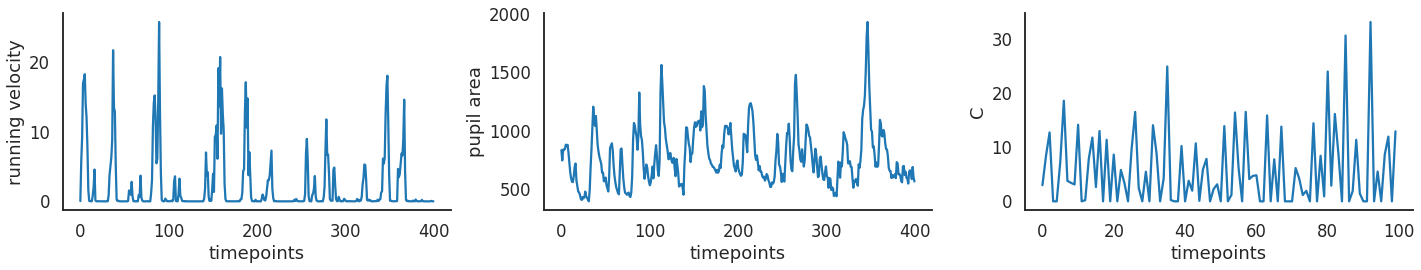

In [51]:
#@title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(131)
plt.plot(dat["run"][:400])
ax.set(xlabel='timepoints', ylabel = 'running velocity')

ax = plt.subplot(132)
plt.plot(dat['pupilArea'][:400,0])
ax.set(xlabel='timepoints', ylabel = 'pupil area')

ax = plt.subplot(133)
plt.plot(dat['sresp'][0,:100])
ax.set(xlabel='timepoints', ylabel = 'C')

[Text(987.2898149507671, 0.5, 'C'),
 Text(0.5, 25.200000000000003, 'timepoints')]

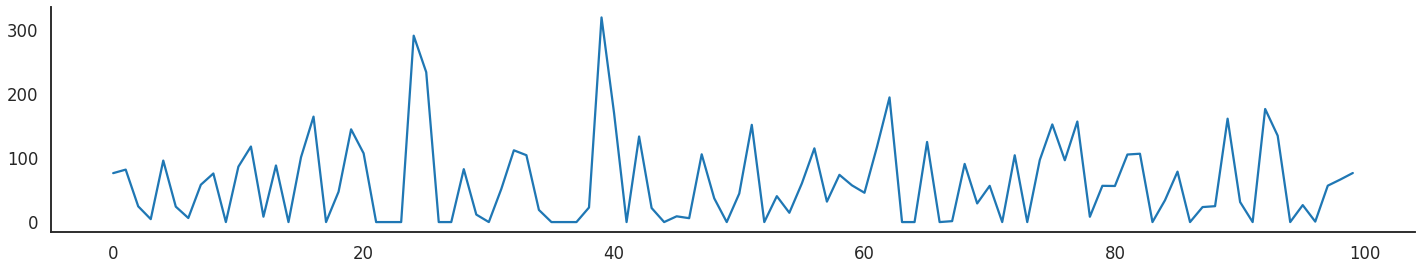

In [43]:
plt.plot(dat['sresp'][90,500:600])
ax.set(xlabel='timepoints', ylabel = 'C')

2073
7018


(0.0, 30.0)

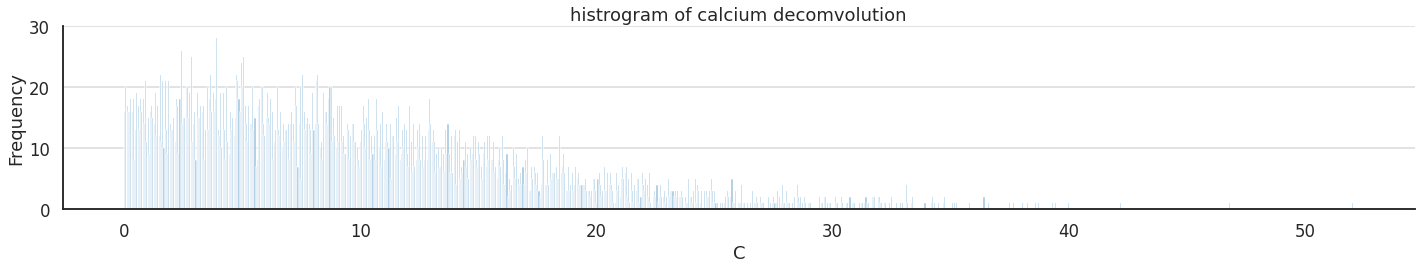

In [44]:
# An "interface" to matplotlib.axes.Axes.hist() method
neu0 = dat["sresp"][0,:]
print (len (neu0[neu0 == 0]))
print (len (neu0))
n, bins, patches = plt.hist(x=neu0 [neu0 != 0], bins=1000,
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('C')
#plt.xlim(0, 10)
plt.ylabel('Frequency')
plt.title('histrogram of calcium decomvolution')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [45]:
#@title Take PCA after preparing data by z-score
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components = 200).fit_transform(Z)

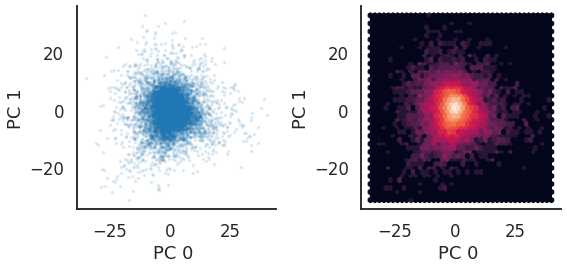

In [46]:
#@title Plot PCs. Too many points, switch to logarithmic hexbin! 
ax = plt.subplot(1,5,1)
plt.scatter(X[:,3], X[:,4], s = 4, alpha = .1)
ax.set(xlabel = 'PC 0 ', ylabel = 'PC 1');

ax = plt.subplot(1,5,2)
plt.hexbin(X[:,3], X[:,4], gridsize = 40, bins = 'log')
ax.set(xlabel = 'PC 0 ', ylabel = 'PC 1', alpha = .1);

In [47]:
dat_C = dat["sresp"].T[:900,:600]
print (dat_C.shape)

(900, 600)


2 states--->
1: baseline
2:  running

In [48]:
num_states = 3    # number of discrete states
obs_dim = dat_C.shape[1]       # dimensionality of observation

# Make an HMM
simple_hmm = ssm.HMM(num_states, obs_dim, observations="ar", transitions="standard")

lls = simple_hmm.fit(dat_C, method='em', num_em_iters=20)

  0%|          | 0/20 [00:00<?, ?it/s]

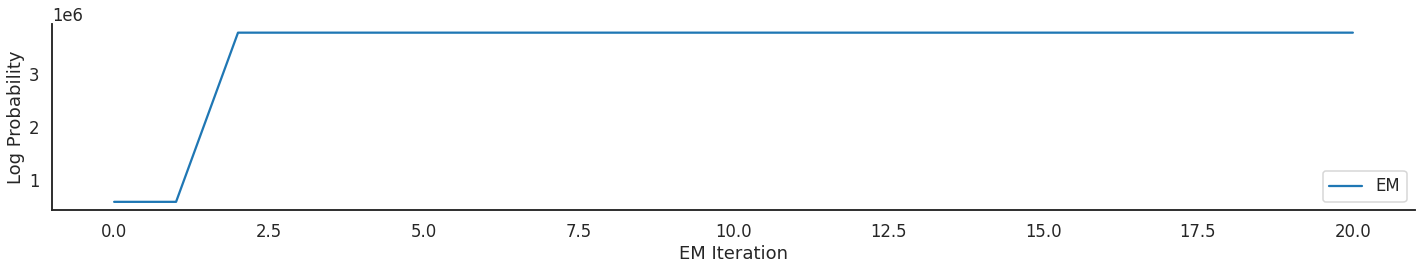

In [49]:
plt.plot(lls, label="EM")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [ ]:
most_likely_states = simple_hmm.most_likely_states(dat_C)

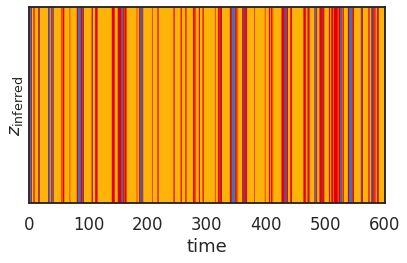

In [ ]:
plt.imshow(most_likely_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, 600 ) #dat_C.shape[0]
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()



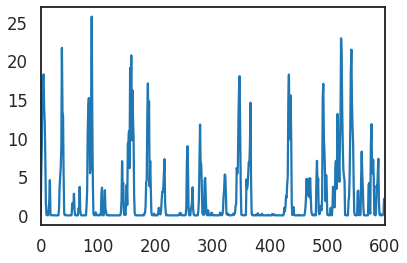

In [ ]:
plt.plot(dat["run"][:600])
plt.xlim(0, 600 )
plt.show()

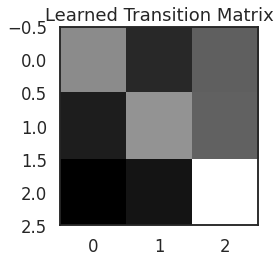

In [ ]:
learned_transition_mat = simple_hmm.transitions.transition_matrix

im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")
#plt.colorbar(im, cax=cbar_ax)
plt.show()